In [1]:
import numpy as np
import os, sys 
import random 
import matplotlib.pyplot as plt
import copy
from torchvision.transforms import ToTensor
import torch 
from torch import linalg as LA
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import random_split
import torchvision.datasets as datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
mnist_trainset = datasets.MNIST(root='/content/drive/My Drive', train=True, download=True, transform=ToTensor())
mnist_testset = datasets.MNIST(root='/content/drive/My Drive', train=False, download=True, transform=ToTensor())

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Deep Learning Model

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.maxpool = nn.MaxPool2d(kernel_size=2)                             
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)         
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)       
        x = F.relu(self.fc1(x))
        output = self.fc2(x)
        return output    

# Centralized Optimization

In [6]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
                 dataset=mnist_trainset,
                 batch_size=batch_size,
                 shuffle=True
                 )

test_loader = torch.utils.data.DataLoader(
                dataset=mnist_testset,
                batch_size=batch_size,
                shuffle=False
                )

In [ ]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.1) 
num_epochs = 100

In [ ]:
torch.manual_seed(10)
all_losses = {'train':[], 'test':[]}
validation_accracy = []
for epoch in range(num_epochs):
    # Training
    batch_loss = 0
    counter = 0
    for batch_data, batch_labels in train_loader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        batch_outputs = model(batch_data)        
        loss = criterion(batch_outputs, batch_labels)
        loss.backward()
        print('Training: ', 'Epoch No: ', epoch+1, 'Iteration No: ', counter+1, '\n',
        'Loss: ', loss.item())
        optimizer.step()
        batch_loss += loss.item()
        counter += 1
    all_losses['train'].append(batch_loss / counter)    
    
    # Validation
    with torch.set_grad_enabled(False):
        batch_losses = []
        counter = 0
        total = 0
        for batch_data, batch_labels in test_loader:
            total += len(batch_data)
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            batch_outputs = model(batch_data)            
            loss = criterion(batch_outputs, batch_labels)
            batch_losses.append(loss.item())
            
            for i in range(len(batch_data)):
                true = int(batch_labels[i])
                pred = int(torch.argmax(batch_outputs[i,:]))
                if pred == true:
                    counter += 1

        all_losses['test'].append(sum(batch_losses) / len(batch_losses))
        print('Validation: ', 'Epoch No: ', epoch+1,'\n',
            'Loss: ', all_losses['test'][-1])
        acc = (counter*100) / total   
        validation_accracy.append(acc)    
        print('validation accuracy: ', acc) 
    if acc >= 99:
        print('99 % accuracy reached!')
        break

Streaming output truncated to the last 5000 lines.
Training:  Epoch No:  9 Iteration No:  320 
 Loss:  0.0017435522750020027
Training:  Epoch No:  9 Iteration No:  321 
 Loss:  0.0001487794506829232
Training:  Epoch No:  9 Iteration No:  322 
 Loss:  0.00110568234231323
Training:  Epoch No:  9 Iteration No:  323 
 Loss:  0.001139216241426766
Training:  Epoch No:  9 Iteration No:  324 
 Loss:  0.0013763989554718137
Training:  Epoch No:  9 Iteration No:  325 
 Loss:  0.0009741192334331572
Training:  Epoch No:  9 Iteration No:  326 
 Loss:  0.00033277482725679874
Training:  Epoch No:  9 Iteration No:  327 
 Loss:  0.001997612416744232
Training:  Epoch No:  9 Iteration No:  328 
 Loss:  0.02146254852414131
Training:  Epoch No:  9 Iteration No:  329 
 Loss:  0.0001703244779491797
Training:  Epoch No:  9 Iteration No:  330 
 Loss:  0.03341437876224518
Training:  Epoch No:  9 Iteration No:  331 
 Loss:  0.0008950140909291804
Training:  Epoch No:  9 Iteration No:  332 
 Loss:  0.00950370542705

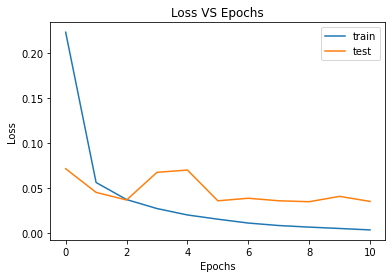

In [ ]:
plt.plot(all_losses['train'], label='train')
plt.plot(all_losses['test'], label='test')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss VS Epochs');

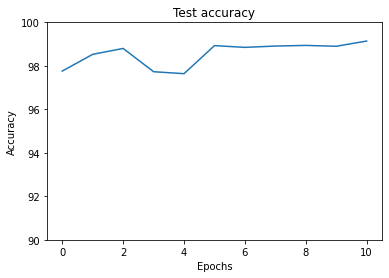

In [ ]:
plt.plot(validation_accracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([90,100])
plt.title('Test accuracy');

# Primal Algorithm(FedAvg)


## Data preprocessing

In [8]:
random.seed(10)

num_users = 100

s = len(mnist_trainset)
client_data_sizes = []
for i in range(num_users-1):
    l = len(mnist_trainset) // num_users
    client_data_sizes.append(l)
    s -= l

client_data_sizes.append(len(mnist_trainset) - sum(client_data_sizes))
 
distributed_train_data = random_split(mnist_trainset, client_data_sizes)

In [9]:
freq = [i/sum(client_data_sizes) for i in client_data_sizes]

In [10]:
batch_size = 10
train_loaders = []
for i in range(num_users):
    train_loaders.append(torch.utils.data.DataLoader(
                 dataset=distributed_train_data[i],
                 batch_size=batch_size,
                 shuffle=True
                 ))

In [11]:
test_loader = torch.utils.data.DataLoader(
                dataset=mnist_testset,
                batch_size=batch_size,
                shuffle=False
                )

In [12]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.1) 
num_epochs = 50

In [ ]:
torch.manual_seed(10)
all_losses = {'train':[], 'test':[]}
validation_accracy = []
for epoch in range(num_epochs):
    print('epoch no', epoch)

    model_weights = copy.deepcopy(model.state_dict())
    averaged_weights = {}
    for layer in model_weights.keys():
        averaged_weights[layer] = torch.zeros_like(model_weights[layer])

    client_losses = []

    for client in random.sample([i for i in range(num_users)], 10):

        client_loss = 0
        counter = 0

        for local_epoch in range(10):
            for batch_data, batch_labels in train_loaders[client]:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
                
                optimizer.zero_grad()
                
                batch_outputs = model(batch_data)        
                loss = criterion(batch_outputs, batch_labels)
                loss.backward()
                optimizer.step()
                client_loss += loss.item()
                counter += 1
            client_losses.append(client_loss / counter)    

        for layer in model.state_dict().keys():
            averaged_weights[layer] += 0.1 * copy.deepcopy(model.state_dict()[layer])

        model.load_state_dict(model_weights)
        
    model.load_state_dict(averaged_weights)  

    all_losses['train'].append(sum(client_losses) / len(client_losses))
    print('Training: ', 'Epoch No: ', epoch+1,'\n',
            'Loss: ', all_losses['train'][-1])


    # Validation
    with torch.set_grad_enabled(False):
        batch_losses = []
        counter = 0
        total = 0
        for batch_data, batch_labels in test_loader:
            total += len(batch_data)
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            batch_outputs = model(batch_data)            
            loss = criterion(batch_outputs, batch_labels)
            batch_losses.append(loss.item())
            
            for i in range(len(batch_data)):
                true = int(batch_labels[i])
                pred = int(torch.argmax(batch_outputs[i,:]))
                if pred == true:
                    counter += 1

        all_losses['test'].append(sum(batch_losses) / len(batch_losses))
        print('Validation: ', 'Epoch No: ', epoch+1,'\n',
            'Loss: ', all_losses['test'][-1])
        acc = (counter*100) / total   
        validation_accracy.append(acc)    

    if acc >= 99:
        print('99 % accuracy reached!')
        break

epoch no 0
Training:  Epoch No:  1 
 Loss:  0.6356174178284973
Validation:  Epoch No:  1 
 Loss:  0.20763978674154895
epoch no 1
Training:  Epoch No:  2 
 Loss:  0.14341998453314095
Validation:  Epoch No:  2 
 Loss:  0.1574986681704424
epoch no 2
Training:  Epoch No:  3 
 Loss:  0.11550691898645389
Validation:  Epoch No:  3 
 Loss:  0.12257898452700124
epoch no 3
Training:  Epoch No:  4 
 Loss:  0.09084691827592102
Validation:  Epoch No:  4 
 Loss:  0.10600796509594256
epoch no 4
Training:  Epoch No:  5 
 Loss:  0.07021566296336877
Validation:  Epoch No:  5 
 Loss:  0.09573893159002682
epoch no 5
Training:  Epoch No:  6 
 Loss:  0.06438860063442314
Validation:  Epoch No:  6 
 Loss:  0.08491580264275678
epoch no 6
Training:  Epoch No:  7 
 Loss:  0.05617526999132744
Validation:  Epoch No:  7 
 Loss:  0.07814615783051848
epoch no 7
Training:  Epoch No:  8 
 Loss:  0.060992168172274416
Validation:  Epoch No:  8 
 Loss:  0.06726221786825563
epoch no 8
Training:  Epoch No:  9 
 Loss:  0.049

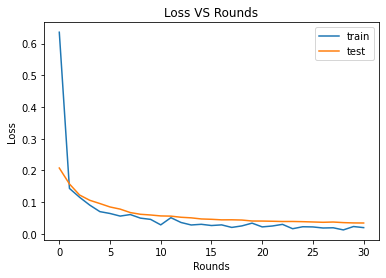

In [ ]:
plt.plot(all_losses['train'], label='train')
plt.plot(all_losses['test'], label='test')
plt.legend()
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.title('Loss VS Rounds');

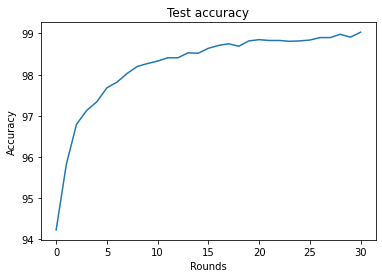

In [ ]:
plt.plot(validation_accracy)
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.title('Test accuracy');

## learning rate = 0.01

In [13]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01) 
num_epochs = 70

In [14]:
torch.manual_seed(10)
all_losses = {'train':[], 'test':[]}
validation_accracy = []
for epoch in range(num_epochs):
    print('epoch no', epoch)

    model_weights = copy.deepcopy(model.state_dict())
    averaged_weights = {}
    for layer in model_weights.keys():
        averaged_weights[layer] = torch.zeros_like(model_weights[layer])

    client_losses = []

    for client in random.sample([i for i in range(num_users)], 10):

        client_loss = 0
        counter = 0

        for local_epoch in range(10):
            for batch_data, batch_labels in train_loaders[client]:
                # Training
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
                
                optimizer.zero_grad()
                
                batch_outputs = model(batch_data)        
                loss = criterion(batch_outputs, batch_labels)
                loss.backward()
                optimizer.step()
                client_loss += loss.item()
                counter += 1
            client_losses.append(client_loss / counter)    

        for layer in model.state_dict().keys():
            averaged_weights[layer] += 0.1 * copy.deepcopy(model.state_dict()[layer])

        model.load_state_dict(model_weights)
        
    model.load_state_dict(averaged_weights)  

    all_losses['train'].append(sum(client_losses) / len(client_losses))
    print('Training: ', 'Epoch No: ', epoch+1,'\n',
            'Loss: ', all_losses['train'][-1])

    # Validation
    with torch.set_grad_enabled(False):
        batch_losses = []
        counter = 0
        total = 0
        for batch_data, batch_labels in test_loader:
            total += len(batch_data)
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            batch_outputs = model(batch_data)            
            loss = criterion(batch_outputs, batch_labels)
            batch_losses.append(loss.item())
            
            for i in range(len(batch_data)):
                true = int(batch_labels[i])
                pred = int(torch.argmax(batch_outputs[i,:]))
                if pred == true:
                    counter += 1

        all_losses['test'].append(sum(batch_losses) / len(batch_losses))
        print('Validation: ', 'Epoch No: ', epoch+1,'\n',
            'Loss: ', all_losses['test'][-1])
        acc = (counter*100) / total   
        validation_accracy.append(acc)    

    if acc >= 99:
        print('99 % accuracy reached!')
        break

epoch no 0
Training:  Epoch No:  1 
 Loss:  1.6771860360259148
Validation:  Epoch No:  1 
 Loss:  0.3595539808999747
epoch no 1
Training:  Epoch No:  2 
 Loss:  0.33117774597137933
Validation:  Epoch No:  2 
 Loss:  0.23952631389867748
epoch no 2
Training:  Epoch No:  3 
 Loss:  0.2147744605335205
Validation:  Epoch No:  3 
 Loss:  0.1924066547870316
epoch no 3
Training:  Epoch No:  4 
 Loss:  0.16047551183824957
Validation:  Epoch No:  4 
 Loss:  0.16026274319270306
epoch no 4
Training:  Epoch No:  5 
 Loss:  0.12621552847951137
Validation:  Epoch No:  5 
 Loss:  0.1390299613149946
epoch no 5
Training:  Epoch No:  6 
 Loss:  0.09835507022166665
Validation:  Epoch No:  6 
 Loss:  0.12518476954605467
epoch no 6
Training:  Epoch No:  7 
 Loss:  0.08768534536351266
Validation:  Epoch No:  7 
 Loss:  0.11415003691103538
epoch no 7
Training:  Epoch No:  8 
 Loss:  0.07889113540240625
Validation:  Epoch No:  8 
 Loss:  0.1037387453202773
epoch no 8
Training:  Epoch No:  9 
 Loss:  0.06883342

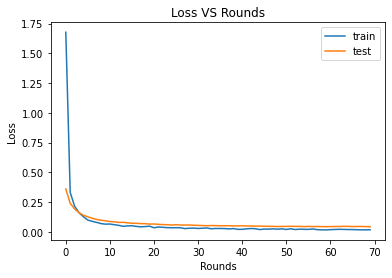

In [15]:
plt.plot(all_losses['train'], label='train')
plt.plot(all_losses['test'], label='test')
plt.legend()
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.title('Loss VS Rounds');

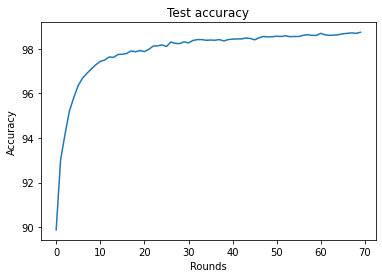

In [16]:
plt.plot(validation_accracy)
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.title('Test accuracy');

In [17]:
max(validation_accracy)

98.75

# FedProx Algorithm

## Data preprocessing

In [7]:
num_users = 100  # number of devices
num_labels = 10

In [8]:
all_indices = [[] for i in range(10)]
for i in range(len(mnist_trainset)):
    label =  mnist_trainset.targets[i]
    all_indices[label].append(i)

In [9]:
partition_indices = {i:[] for i in range(100)}

for label in range(10):
    for user in range(num_users):  
        if len(all_indices[label]) == 0:
            break
        elif len(partition_indices[user]) <= 300:    
            partition_indices[user] += all_indices[label][0:300]
            del all_indices[label][0:300]

In [10]:
partition_indices[99] += all_indices[9][0:400]
del all_indices[9][0:400]

partition_indices[98] += all_indices[9][0:400]
del all_indices[9][0:400]

partition_indices[97] += all_indices[9][0:400]
del all_indices[9][0:400]

In [11]:
class mnist_non_iid_Dataset(torch.utils.data.Dataset):
    def __init__(self, indices):
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self,ind):
        return  mnist_trainset[self.indices[ind]]

In [12]:
batch_size = 10
train_loaders = []
for i in range(num_users):
    train_loaders.append(torch.utils.data.DataLoader(
                 dataset=mnist_non_iid_Dataset(partition_indices[i]),
                 batch_size=batch_size,
                 shuffle=True
                 ))

In [13]:
test_loader = torch.utils.data.DataLoader(
                dataset=mnist_testset,
                batch_size=batch_size,
                shuffle=False
                )

## Define loss function

In [14]:
def loss_function(global_weights, local_weights, net_output, batch_labels):
    criterion = nn.CrossEntropyLoss()
    loss1  = criterion(net_output, batch_labels)
    loss2 = 0
    for layer in global_weights.keys():
        loss2 += (LA.matrix_norm(global_weights[layer].flatten().unsqueeze(-1) - local_weights[layer].flatten().unsqueeze(-1))) **2

    return loss1 + (mu/2) * (loss2)    

In [ ]:
model = CNN().to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.1) 
criterion = nn.CrossEntropyLoss()
num_epochs = 300
mu = 3

In [ ]:
torch.manual_seed(10)
all_losses = {'train':[], 'test':[]}
validation_accracy = []
for epoch in range(num_epochs):
    print('epoch no', epoch)

    model_weights = copy.deepcopy(model.state_dict())
    averaged_weights = {}
    for layer in model_weights.keys():
        averaged_weights[layer] = torch.zeros_like(model_weights[layer])

    client_losses = []

    random_clients = random.sample([i for i in range(num_users)], 10)
    total_samples = 0
    for element in random_clients:
        total_samples += len(train_loaders[element])

    freq = {}
    for element in random_clients:
        freq[element] = len(train_loaders[element]) / total_samples

    for client in random_clients:

        client_loss = 0
        counter = 0

        for local_epoch in range(5):
            for batch_data, batch_labels in train_loaders[client]:
                # Training
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
                
                optimizer.zero_grad()
                
                batch_outputs = model(batch_data)        
                loss = loss_function(model_weights, model.state_dict(), batch_outputs, batch_labels)
                loss.backward()
                optimizer.step()
                client_loss += loss.item()
                counter += 1
            client_losses.append(client_loss / counter)    
        
        for layer in model.state_dict().keys():
            averaged_weights[layer] += freq[client] * copy.deepcopy(model.state_dict()[layer])

        model.load_state_dict(model_weights)
        
    model.load_state_dict(averaged_weights)  

    all_losses['train'].append(sum([a*b for a,b in zip(client_losses,list(freq.values()))]))
    

    print('Training: ', 'Epoch No: ', epoch+1,'\n',
            'Loss: ', all_losses['train'][-1])


    # Validation
    with torch.set_grad_enabled(False):
        batch_losses = []
        counter = 0
        total = 0
        for batch_data, batch_labels in test_loader:
            total += len(batch_data)
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            batch_outputs = model(batch_data)            
            loss = criterion(batch_outputs, batch_labels)
            batch_losses.append(loss.item())
            
            for i in range(len(batch_data)):
                true = int(batch_labels[i])
                pred = int(torch.argmax(batch_outputs[i,:]))
                if pred == true:
                    counter += 1

        all_losses['test'].append(sum(batch_losses) / len(batch_losses))
        print('Validation: ', 'Epoch No: ', epoch+1,'\n',
            'Loss: ', all_losses['test'][-1])
        acc = (counter*100) / total   
        validation_accracy.append(acc)    
        print('validation accuracy: ', acc)

    if acc >= 95:
        print('95 % accuracy reached!')
        break

epoch no 0
Training:  Epoch No:  1 
 Loss:  5.726013383017923
Validation:  Epoch No:  1 
 Loss:  2.049858866095543
validation accuracy:  23.64
epoch no 1
Training:  Epoch No:  2 
 Loss:  3.29981167709613
Validation:  Epoch No:  2 
 Loss:  1.653504260957241
validation accuracy:  50.91
epoch no 2
Training:  Epoch No:  3 
 Loss:  2.8541637406039717
Validation:  Epoch No:  3 
 Loss:  1.501644079685211
validation accuracy:  49.73
epoch no 3
Training:  Epoch No:  4 
 Loss:  0.9965762579271363
Validation:  Epoch No:  4 
 Loss:  1.3539879039227962
validation accuracy:  50.49
epoch no 4
Training:  Epoch No:  5 
 Loss:  2.6306469163230677
Validation:  Epoch No:  5 
 Loss:  2.882657174766064
validation accuracy:  42.85
epoch no 5
Training:  Epoch No:  6 
 Loss:  4.8553454745129905
Validation:  Epoch No:  6 
 Loss:  0.759196814775467
validation accuracy:  73.47
epoch no 6
Training:  Epoch No:  7 
 Loss:  1.20967754904098
Validation:  Epoch No:  7 
 Loss:  0.5411264705248177
validation accuracy:  8

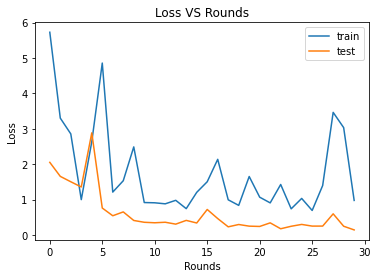

In [ ]:
plt.plot(all_losses['train'], label='train')
plt.plot(all_losses['test'], label='test')
plt.legend()
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.title('Loss VS Rounds');

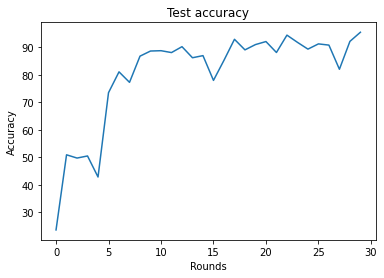

In [ ]:
plt.plot(validation_accracy)
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.title('Test accuracy');

In [ ]:
max(validation_accracy)

95.39

## learning rate = 0.01

In [14]:
model = CNN().to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.01) 
criterion = nn.CrossEntropyLoss()
num_epochs = 300
mu = 3

In [15]:
torch.manual_seed(10)
all_losses = {'train':[], 'test':[]}
validation_accracy = []
for epoch in range(num_epochs):
    print('epoch no', epoch)

    model_weights = copy.deepcopy(model.state_dict())
    averaged_weights = {}
    for layer in model_weights.keys():
        averaged_weights[layer] = torch.zeros_like(model_weights[layer])

    client_losses = []

    random_clients = random.sample([i for i in range(num_users)], 10)
    total_samples = 0
    for element in random_clients:
        total_samples += len(train_loaders[element])

    freq = {}
    for element in random_clients:
        freq[element] = len(train_loaders[element]) / total_samples

    for client in random_clients:

        client_loss = 0
        counter = 0

        for local_epoch in range(5):
            for batch_data, batch_labels in train_loaders[client]:
                # Training
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
                
                optimizer.zero_grad()
                
                batch_outputs = model(batch_data)        
                loss = loss_function(model_weights, model.state_dict(), batch_outputs, batch_labels)
                loss.backward()
                optimizer.step()
                client_loss += loss.item()
                counter += 1
            client_losses.append(client_loss / counter)    
        
        for layer in model.state_dict().keys():
            averaged_weights[layer] += freq[client] * copy.deepcopy(model.state_dict()[layer])

        model.load_state_dict(model_weights)
        
    model.load_state_dict(averaged_weights)  

    all_losses['train'].append(sum([a*b for a,b in zip(client_losses,list(freq.values()))]))
    

    print('Training: ', 'Epoch No: ', epoch+1,'\n',
            'Loss: ', all_losses['train'][-1])


    # Validation
    with torch.set_grad_enabled(False):
        batch_losses = []
        counter = 0
        total = 0
        for batch_data, batch_labels in test_loader:
            total += len(batch_data)
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            batch_outputs = model(batch_data)            
            loss = criterion(batch_outputs, batch_labels)
            batch_losses.append(loss.item())
            
            for i in range(len(batch_data)):
                true = int(batch_labels[i])
                pred = int(torch.argmax(batch_outputs[i,:]))
                if pred == true:
                    counter += 1

        all_losses['test'].append(sum(batch_losses) / len(batch_losses))
        print('Validation: ', 'Epoch No: ', epoch+1,'\n',
            'Loss: ', all_losses['test'][-1])
        acc = (counter*100) / total   
        validation_accracy.append(acc)    
        print('validation accuracy: ', acc)

    if acc >= 95:
        print('95 % accuracy reached!')
        break

epoch no 0
Training:  Epoch No:  1 
 Loss:  1.695860435234176
Validation:  Epoch No:  1 
 Loss:  3.080661289334297
validation accuracy:  19.27
epoch no 1
Training:  Epoch No:  2 
 Loss:  0.6596546377729176
Validation:  Epoch No:  2 
 Loss:  2.795608528137207
validation accuracy:  30.51
epoch no 2
Training:  Epoch No:  3 
 Loss:  0.6992351052195074
Validation:  Epoch No:  3 
 Loss:  1.5260534834861756
validation accuracy:  49.08
epoch no 3
Training:  Epoch No:  4 
 Loss:  0.6101997790354732
Validation:  Epoch No:  4 
 Loss:  1.5045503205657005
validation accuracy:  47.98
epoch no 4
Training:  Epoch No:  5 
 Loss:  0.25525319460358464
Validation:  Epoch No:  5 
 Loss:  1.2156576247513293
validation accuracy:  55.53
epoch no 5
Training:  Epoch No:  6 
 Loss:  0.5795076310308651
Validation:  Epoch No:  6 
 Loss:  1.141354898005724
validation accuracy:  56.09
epoch no 6
Training:  Epoch No:  7 
 Loss:  0.23920086135353066
Validation:  Epoch No:  7 
 Loss:  1.314440350741148
validation accur

KeyboardInterrupt: ignored

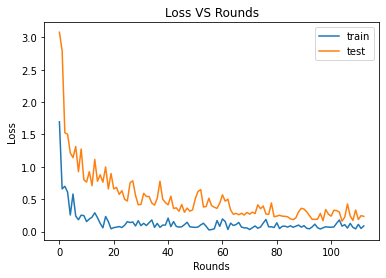

In [16]:
plt.plot(all_losses['train'], label='train')
plt.plot(all_losses['test'], label='test')
plt.legend()
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.title('Loss VS Rounds');

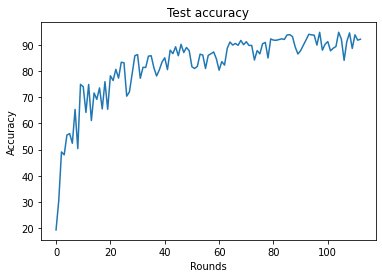

In [17]:
plt.plot(validation_accracy)
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.title('Test accuracy');

## Clients with different computational power

In [15]:
clients_power = []
for i in range(num_users):
    clients_power.append(random.randrange(2,11))

## learning rate = 0.01

In [19]:
model = CNN().to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.01) 
criterion = nn.CrossEntropyLoss()
num_epochs = 70
mu = 3

In [20]:
torch.manual_seed(10)
all_losses = {'train':[], 'test':[]}
validation_accracy = []
for epoch in range(num_epochs):
    print('epoch no', epoch)

    model_weights = copy.deepcopy(model.state_dict())
    averaged_weights = {}
    for layer in model_weights.keys():
        averaged_weights[layer] = torch.zeros_like(model_weights[layer])

    client_losses = []

    random_clients = random.sample([i for i in range(num_users)], 10)
    total_samples = 0
    for element in random_clients:
        total_samples += len(train_loaders[element])

    freq = {}
    for element in random_clients:
        freq[element] = len(train_loaders[element]) / total_samples

    for client in random_clients:

        client_loss = 0
        counter = 0

        for local_epoch in range(clients_power[client]):
            for batch_data, batch_labels in train_loaders[client]:
                # Training
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
                
                optimizer.zero_grad()
                
                batch_outputs = model(batch_data)        
                loss = loss_function(model_weights, model.state_dict(), batch_outputs, batch_labels)
                loss.backward()
                optimizer.step()
                client_loss += loss.item()
                counter += 1
            client_losses.append(client_loss / counter)    
        
        for layer in model.state_dict().keys():
            averaged_weights[layer] += freq[client] * copy.deepcopy(model.state_dict()[layer])

        model.load_state_dict(model_weights)
        
    model.load_state_dict(averaged_weights)  

    all_losses['train'].append(sum([a*b for a,b in zip(client_losses,list(freq.values()))]))
    

    print('Training: ', 'Epoch No: ', epoch+1,'\n',
            'Loss: ', all_losses['train'][-1])


    # Validation
    with torch.set_grad_enabled(False):
        batch_losses = []
        counter = 0
        total = 0
        for batch_data, batch_labels in test_loader:
            total += len(batch_data)
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            batch_outputs = model(batch_data)            
            loss = criterion(batch_outputs, batch_labels)
            batch_losses.append(loss.item())
            
            for i in range(len(batch_data)):
                true = int(batch_labels[i])
                pred = int(torch.argmax(batch_outputs[i,:]))
                if pred == true:
                    counter += 1

        all_losses['test'].append(sum(batch_losses) / len(batch_losses))
        print('Validation: ', 'Epoch No: ', epoch+1,'\n',
            'Loss: ', all_losses['test'][-1])
        acc = (counter*100) / total   
        validation_accracy.append(acc)    
        print('validation accuracy: ', acc)

    if acc >= 95:
        print('95 % accuracy reached!')
        break

epoch no 0
Training:  Epoch No:  1 
 Loss:  1.7789729139621242
Validation:  Epoch No:  1 
 Loss:  3.1468099937438967
validation accuracy:  19.2
epoch no 1
Training:  Epoch No:  2 
 Loss:  0.9772735019468126
Validation:  Epoch No:  2 
 Loss:  1.8916505951881408
validation accuracy:  36.78
epoch no 2
Training:  Epoch No:  3 
 Loss:  0.36906357491326414
Validation:  Epoch No:  3 
 Loss:  1.6620984825491905
validation accuracy:  44.48
epoch no 3
Training:  Epoch No:  4 
 Loss:  0.284387506259867
Validation:  Epoch No:  4 
 Loss:  1.9522831510305405
validation accuracy:  26.52
epoch no 4
Training:  Epoch No:  5 
 Loss:  0.36340216712861656
Validation:  Epoch No:  5 
 Loss:  1.4478344997763635
validation accuracy:  42.08
epoch no 5
Training:  Epoch No:  6 
 Loss:  0.22801957610723667
Validation:  Epoch No:  6 
 Loss:  1.5706695396304131
validation accuracy:  44.83
epoch no 6
Training:  Epoch No:  7 
 Loss:  0.2243858355380526
Validation:  Epoch No:  7 
 Loss:  1.649694757193327
validation ac

KeyboardInterrupt: ignored

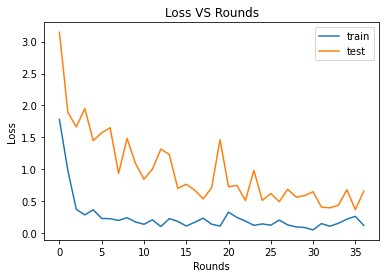

In [21]:
plt.plot(all_losses['train'], label='train')
plt.plot(all_losses['test'], label='test')
plt.legend()
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.title('Loss VS Rounds');

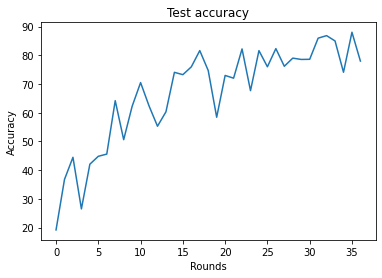

In [22]:
plt.plot(validation_accracy)
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.title('Test accuracy');